# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), reflect_z=False,
                             input_pipe=None, rot_mult=4)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 8


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


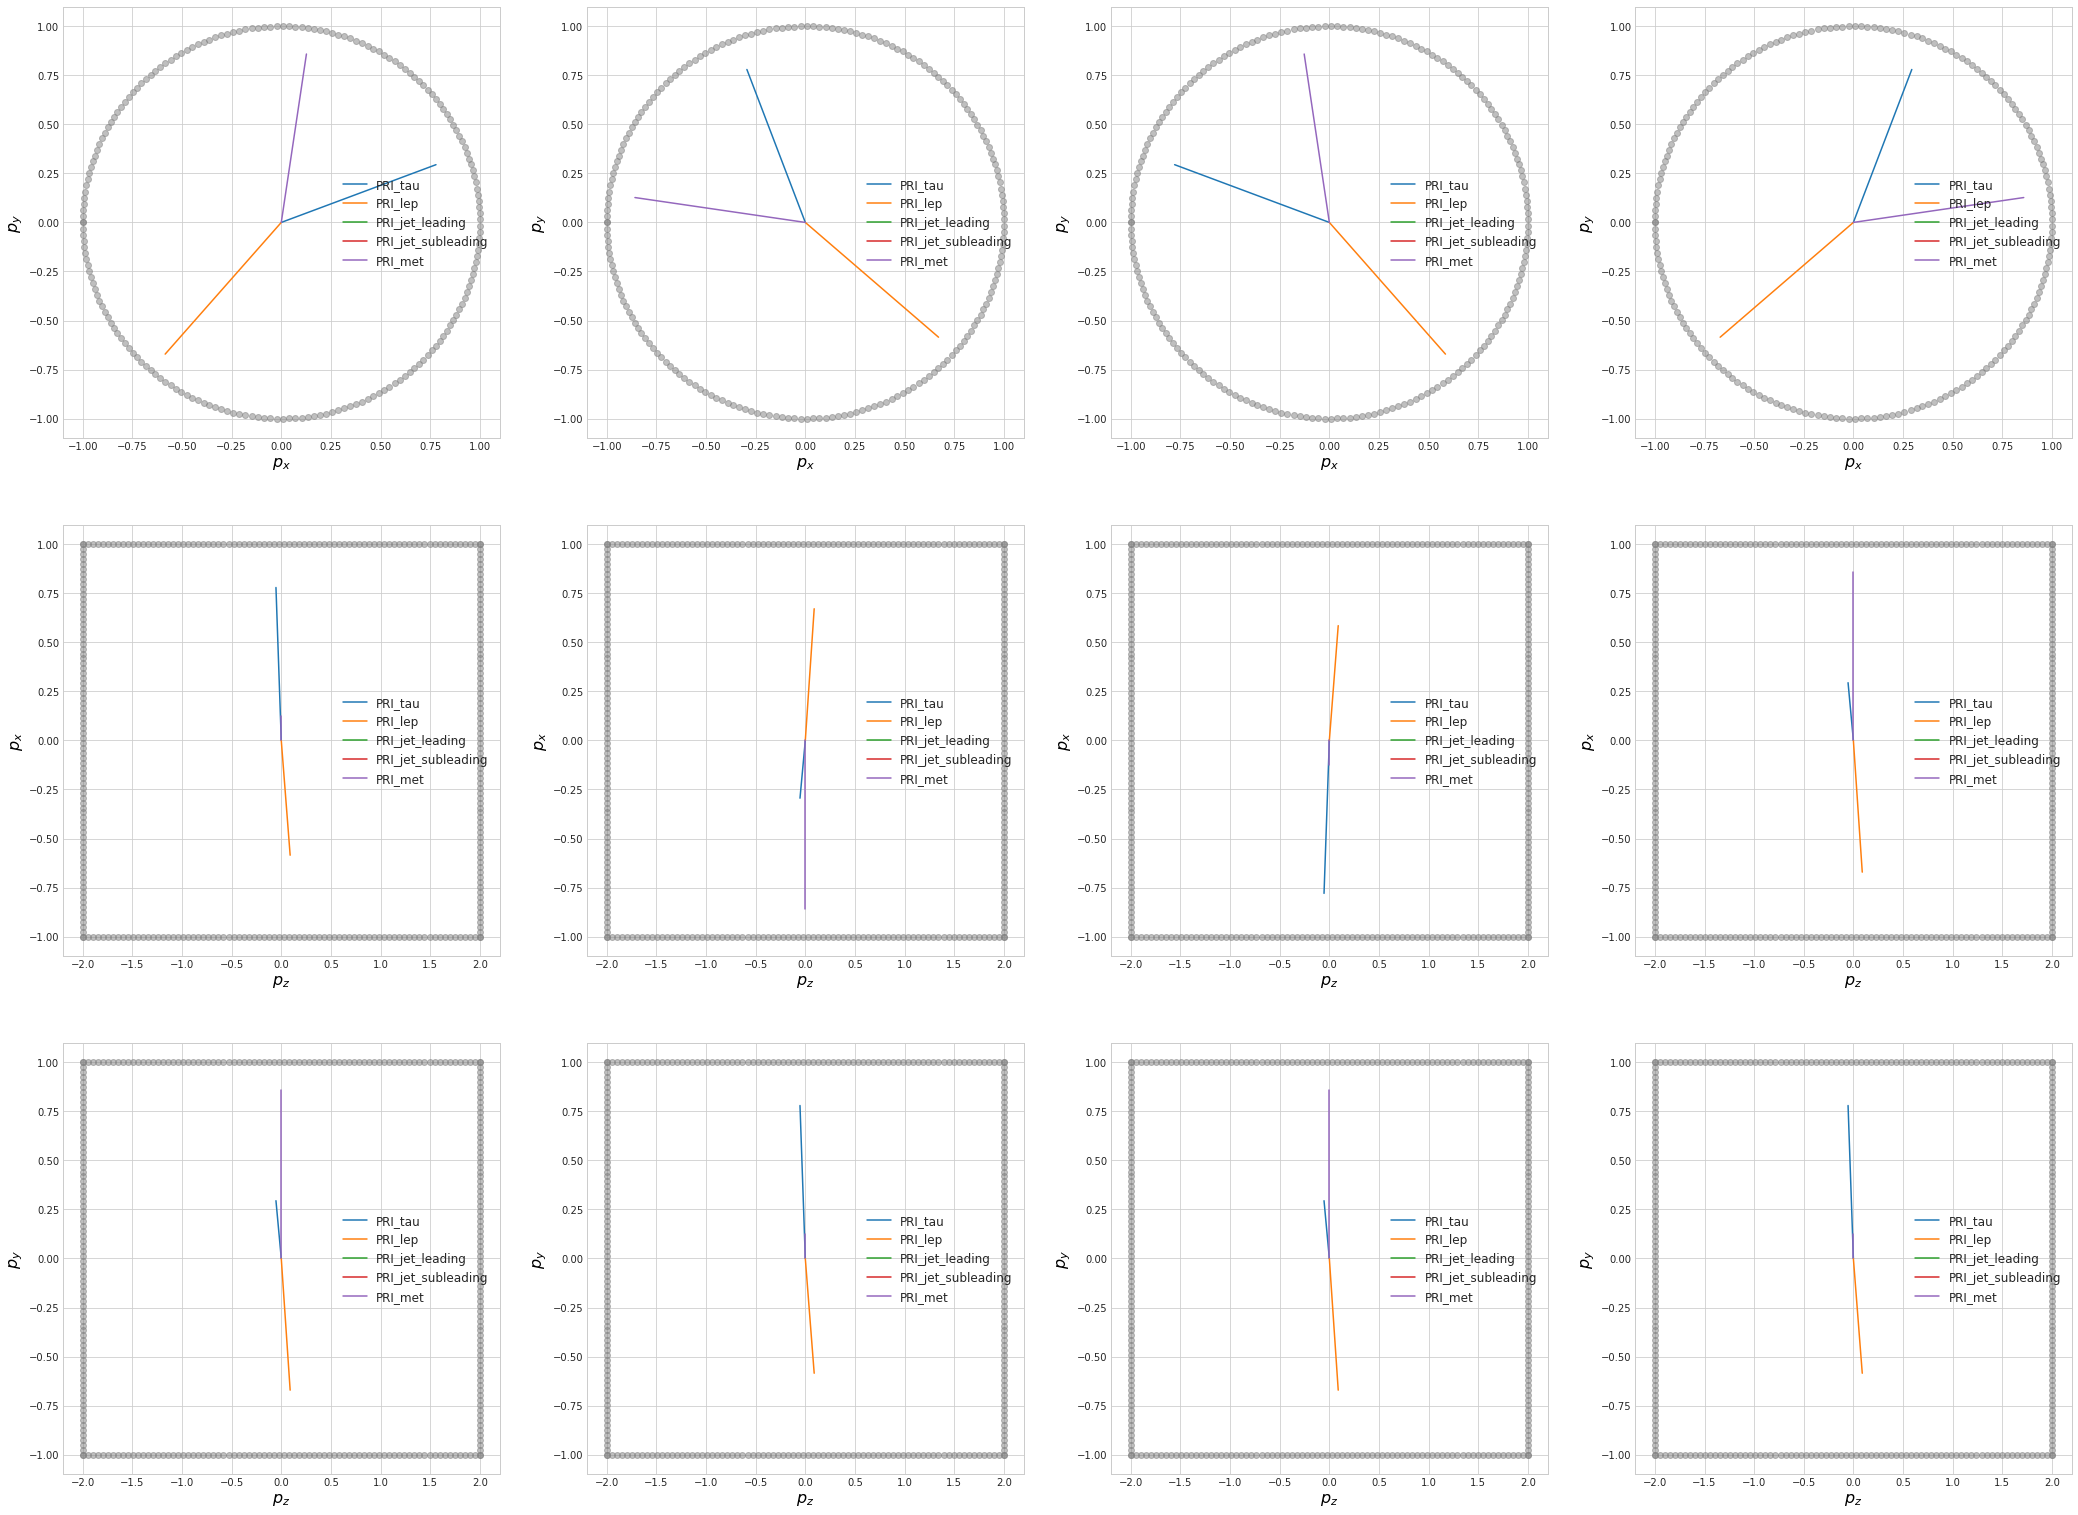

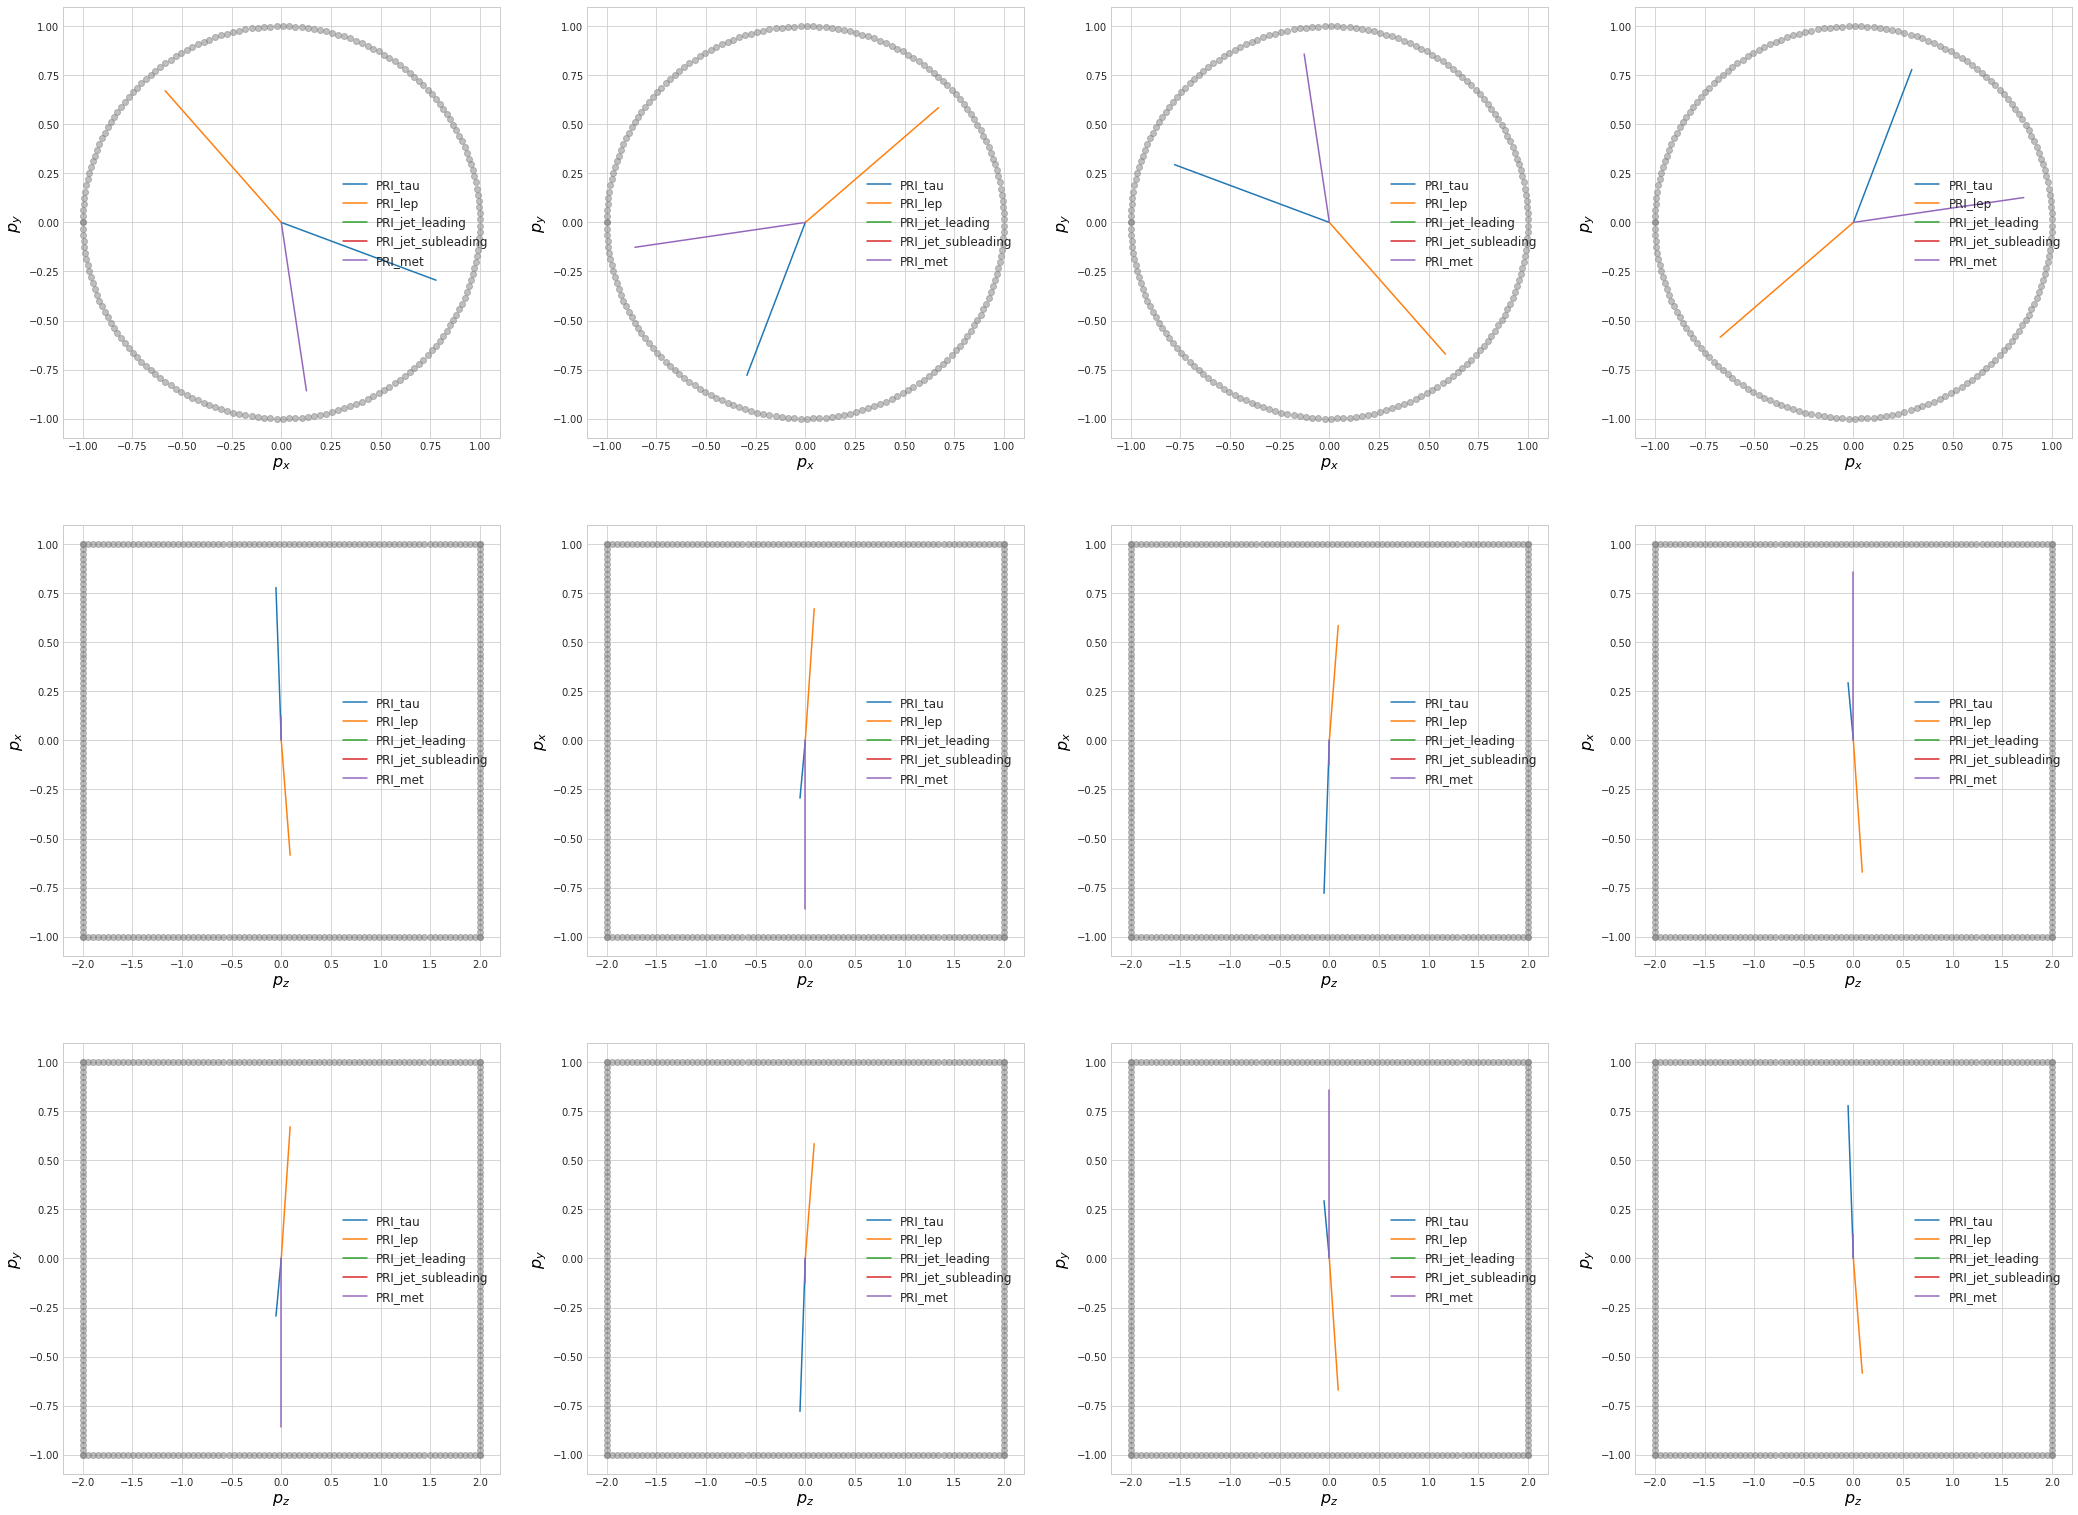

In [6]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 16.750s 


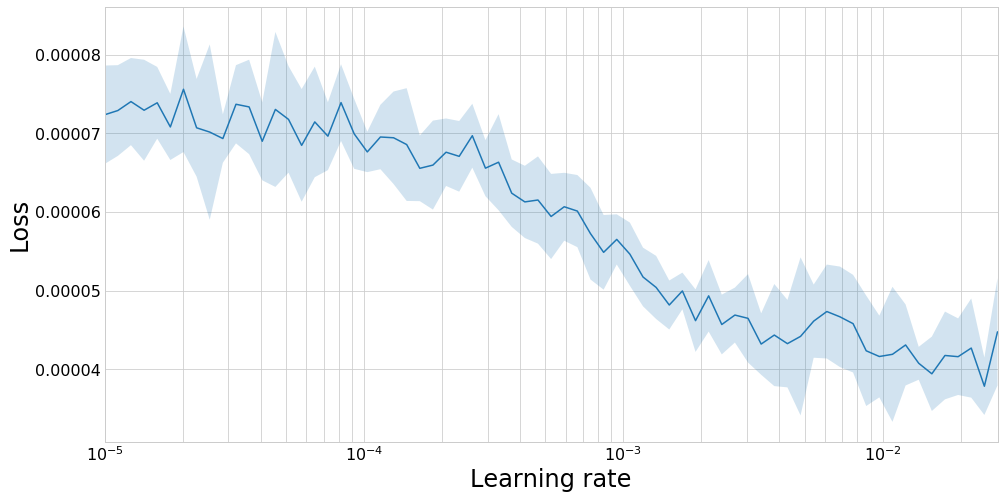

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105629). Check your callbacks.
  % delta_t_median)


1 New best found: 4.031572880779124e-05
2 New best found: 3.7081077477699054e-05
3 New best found: 3.6275165189268826e-05
4 New best found: 3.612755905884425e-05
5 New best found: 3.535389046417788e-05
6 New best found: 3.503002812573166e-05
7 New best found: 3.4901262267871405e-05
10 New best found: 3.479074722122772e-05
11 New best found: 3.4178900399748e-05
13 New best found: 3.387019399543228e-05
14 New best found: 3.372296537820859e-05
15 New best found: 3.371797890258078e-05
22 New best found: 3.357099047909231e-05
25 New best found: 3.336315607439442e-05
26 New best found: 3.322651860596842e-05
27 New best found: 3.313622513473257e-05
29 New best found: 3.311487288828143e-05
30 New best found: 3.3086655676135715e-05
31 New best found: 3.307732779733346e-05
50 New best found: 3.302252988321858e-05
52 New best found: 3.299101343722606e-05
53 New best found: 3.2800220769610395e-05
57 New best found: 3.279968085782868e-05
58 New best found: 3.2787797769783403e-05
59 New best found: 

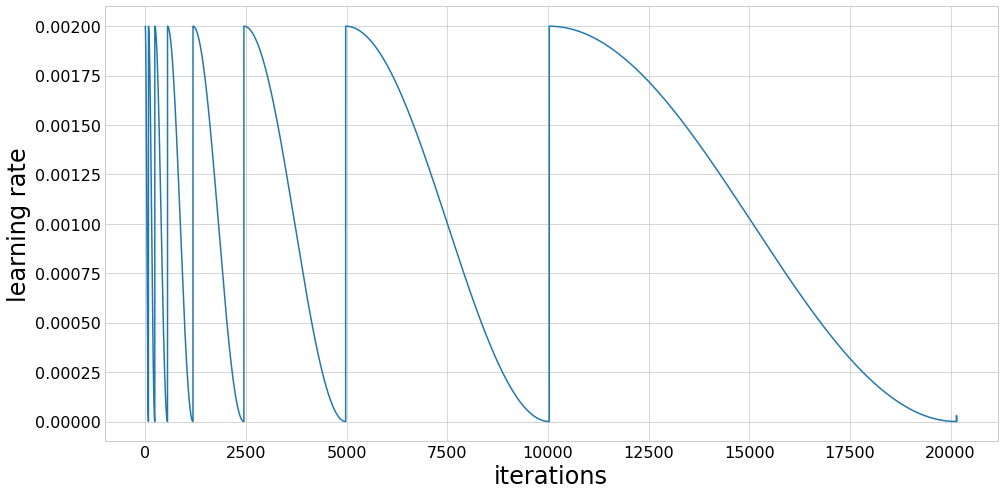

Fold took 228.419s

Training model 2 / 10
Using cosine LR annealing
1 New best found: 3.958013603838466e-05
2 New best found: 3.680568761974399e-05
3 New best found: 3.524862965643159e-05
5 New best found: 3.440314340949904e-05
6 New best found: 3.421398616071127e-05
7 New best found: 3.3884283795110536e-05
11 New best found: 3.3720814141327246e-05
12 New best found: 3.333932854209732e-05
13 New best found: 3.324374741113937e-05
14 New best found: 3.311044408336463e-05
21 New best found: 3.309807247561394e-05
23 New best found: 3.289859399844141e-05
25 New best found: 3.278070175434798e-05
26 New best found: 3.276802469052125e-05
27 New best found: 3.2646328798819306e-05
28 New best found: 3.2598609272647784e-05
30 New best found: 3.255095853739785e-05
31 New best found: 3.2545821443102925e-05
48 New best found: 3.240719457112939e-05
50 New best found: 3.2345568956683344e-05
51 New best found: 3.224667358690836e-05
53 New best found: 3.222854340624922e-05
56 New best found: 3.220385161

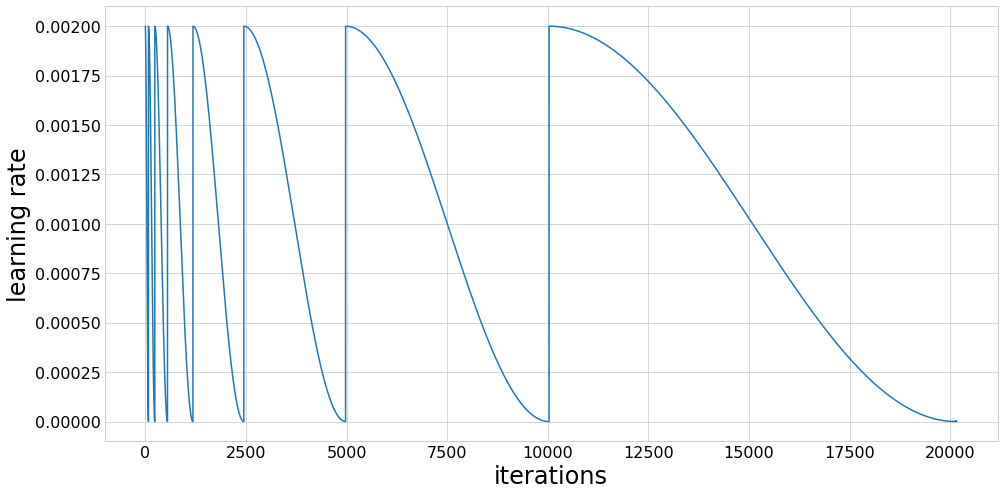

Fold took 237.986s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.260224). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130442). Check your callbacks.
  % delta_t_median)


1 New best found: 3.997165433684131e-05
2 New best found: 3.8164839503588156e-05
3 New best found: 3.6958844331093134e-05
4 New best found: 3.660446921421681e-05
5 New best found: 3.623212560050888e-05
6 New best found: 3.520820138219278e-05
7 New best found: 3.511441626615124e-05
11 New best found: 3.4702252679562665e-05
12 New best found: 3.458133432432078e-05
13 New best found: 3.433618760318495e-05
14 New best found: 3.408356488944264e-05
15 New best found: 3.407182334776735e-05
21 New best found: 3.394548680516891e-05
23 New best found: 3.394330222654389e-05
24 New best found: 3.388255609170301e-05
26 New best found: 3.368296729167924e-05
27 New best found: 3.363225453649647e-05
28 New best found: 3.3544485132733826e-05
47 New best found: 3.3519779620110056e-05
50 New best found: 3.343278772663325e-05
54 New best found: 3.340704250440467e-05
57 New best found: 3.337906122760614e-05
58 New best found: 3.3359482248488345e-05
59 New best found: 3.335470642487053e-05
60 New best found

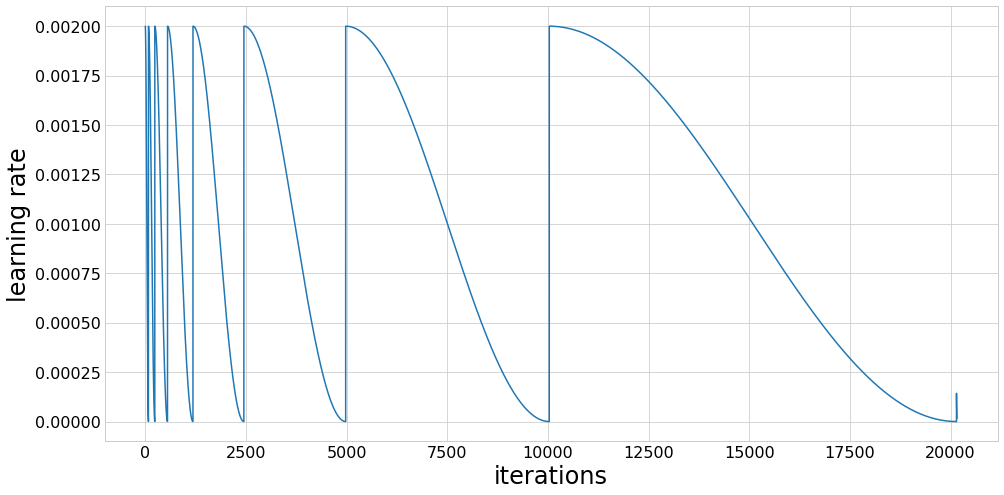

Fold took 231.137s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.262397). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131563). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8415783682701236e-05
2 New best found: 3.5988149000591496e-05
3 New best found: 3.501629275542445e-05
4 New best found: 3.438754687137426e-05
5 New best found: 3.4137104032114536e-05
6 New best found: 3.361928060012645e-05
7 New best found: 3.350790646737627e-05
11 New best found: 3.333812508623484e-05
12 New best found: 3.290967051219039e-05
13 New best found: 3.261506575606566e-05
14 New best found: 3.246094810123687e-05
22 New best found: 3.2437865500421686e-05
23 New best found: 3.238920372077221e-05
24 New best found: 3.217231806947621e-05
25 New best found: 3.217036864330598e-05
26 New best found: 3.209500501254957e-05
28 New best found: 3.2058741377197016e-05
29 New best found: 3.1946656073918265e-05
30 New best found: 3.188664220905914e-05
31 New best found: 3.187469451891023e-05
50 New best found: 3.164611598699586e-05
53 New best found: 3.154802375301188e-05
54 New best found: 3.1519699299638704e-05
56 New best found: 3.147027109932865e-05
58 New best foun

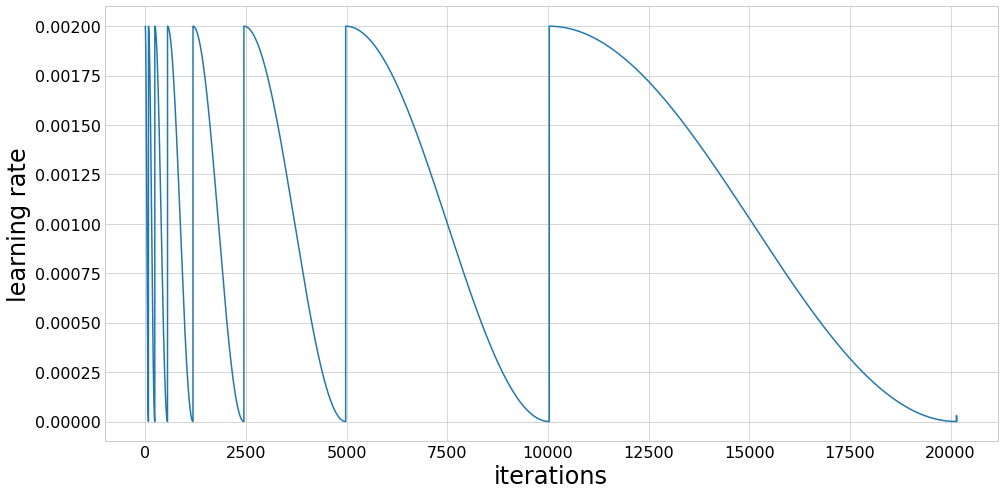

Fold took 239.176s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.307983). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154344). Check your callbacks.
  % delta_t_median)


1 New best found: 3.974083782747079e-05
2 New best found: 3.6890094958487526e-05
3 New best found: 3.587400909173681e-05
4 New best found: 3.5212035018227665e-05
5 New best found: 3.5079944128959665e-05
6 New best found: 3.420007109506695e-05
7 New best found: 3.391267456427215e-05
9 New best found: 3.3762063250702425e-05
11 New best found: 3.3746534302684404e-05
12 New best found: 3.322913101019033e-05
13 New best found: 3.307837590141078e-05
14 New best found: 3.295468947964185e-05
23 New best found: 3.283231875867577e-05
25 New best found: 3.271568435717933e-05
26 New best found: 3.2583195027009526e-05
27 New best found: 3.251175475999835e-05
28 New best found: 3.248633349946551e-05
29 New best found: 3.243951660213968e-05
30 New best found: 3.2425984094814084e-05
31 New best found: 3.2414577194164593e-05
52 New best found: 3.2283467866559665e-05
54 New best found: 3.218686628960072e-05
56 New best found: 3.218257065803528e-05
57 New best found: 3.2134129481028724e-05
59 New best fo

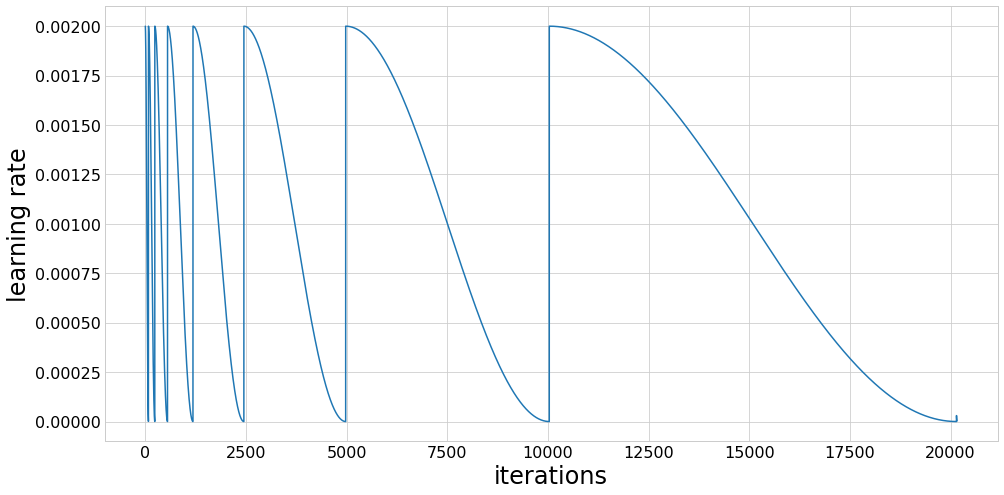

Fold took 242.062s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.312751). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.156723). Check your callbacks.
  % delta_t_median)


1 New best found: 3.8848052761750296e-05
2 New best found: 3.57262890189304e-05
3 New best found: 3.512766161875334e-05
4 New best found: 3.467253387061646e-05
5 New best found: 3.405711365339812e-05
6 New best found: 3.338108174211811e-05
7 New best found: 3.327845043095294e-05
10 New best found: 3.3096455530903766e-05
11 New best found: 3.2775640436739194e-05
12 New best found: 3.2445387488405686e-05
13 New best found: 3.2384417403955014e-05
14 New best found: 3.227375485002994e-05
15 New best found: 3.219667059020139e-05
20 New best found: 3.216353846073616e-05
21 New best found: 3.214320547267562e-05
25 New best found: 3.1707914528669787e-05
26 New best found: 3.1590293678164016e-05
27 New best found: 3.1572366242471614e-05
29 New best found: 3.147541327925865e-05
30 New best found: 3.1458114917040804e-05
31 New best found: 3.145419042411959e-05
47 New best found: 3.132518452621298e-05
53 New best found: 3.1230090055032636e-05
54 New best found: 3.114996557851555e-05
56 New best fo

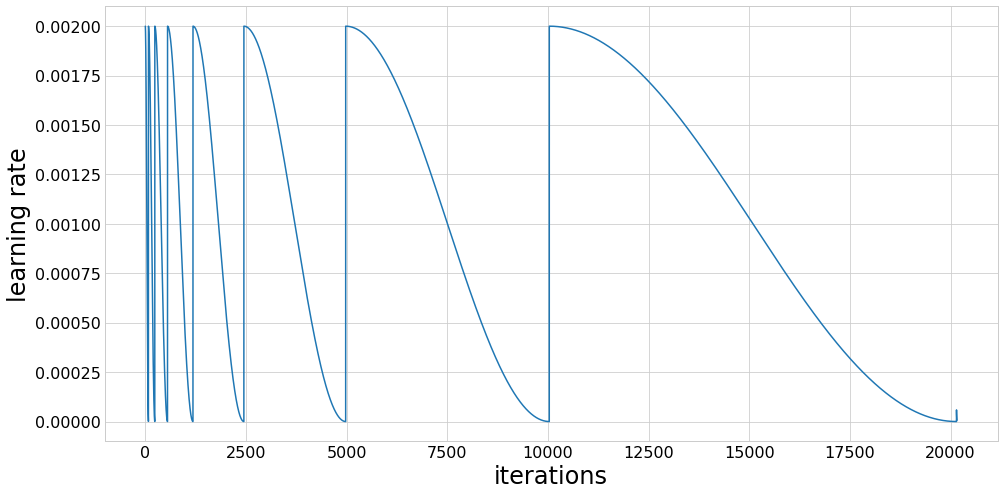

Fold took 246.177s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.314514). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157616). Check your callbacks.
  % delta_t_median)


1 New best found: 3.952426895557437e-05
2 New best found: 3.595669200003613e-05
3 New best found: 3.555055920733139e-05
4 New best found: 3.503964340197854e-05
5 New best found: 3.470076431403868e-05
6 New best found: 3.3925310819904555e-05
7 New best found: 3.375189718935872e-05
11 New best found: 3.3396551619807723e-05
12 New best found: 3.3182991393550765e-05
13 New best found: 3.285014802022488e-05
14 New best found: 3.276857587043196e-05
25 New best found: 3.246704965131357e-05
26 New best found: 3.2418705149029845e-05
27 New best found: 3.213416971993865e-05
30 New best found: 3.212221114954445e-05
31 New best found: 3.211277375885402e-05
47 New best found: 3.203363177162828e-05
52 New best found: 3.184706088068197e-05
55 New best found: 3.184481916687219e-05
56 New best found: 3.178114511101739e-05
95 New best found: 3.1768144220404795e-05
98 New best found: 3.171921125976951e-05
99 New best found: 3.16548715083627e-05
101 New best found: 3.163423446312663e-05
103 New best found

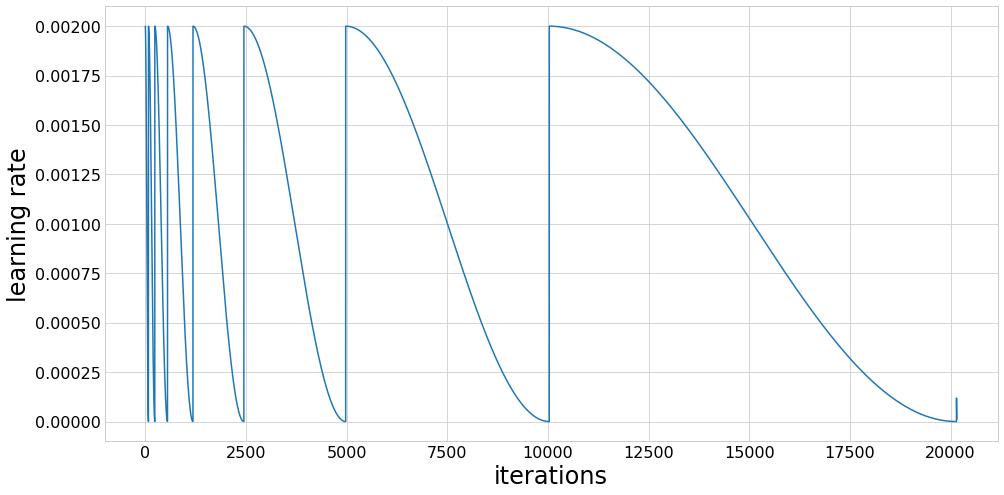

Fold took 248.341s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.395876). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198329). Check your callbacks.
  % delta_t_median)


1 New best found: 3.978941433306318e-05
2 New best found: 3.7541335410787725e-05
3 New best found: 3.615812284842832e-05
4 New best found: 3.5761255450779574e-05
5 New best found: 3.540164226214984e-05
6 New best found: 3.479370519635268e-05
7 New best found: 3.460566449502949e-05
10 New best found: 3.460146413417533e-05
11 New best found: 3.4420872687041994e-05
12 New best found: 3.384014140901854e-05
13 New best found: 3.381359345221426e-05
14 New best found: 3.3529359820386164e-05
15 New best found: 3.3519991936918816e-05
21 New best found: 3.350638203701237e-05
24 New best found: 3.3369822017266415e-05
25 New best found: 3.3203376800520344e-05
26 New best found: 3.303886005378445e-05
27 New best found: 3.303027793663204e-05
28 New best found: 3.293279049466946e-05
29 New best found: 3.2889878927380776e-05
50 New best found: 3.288752779481001e-05
51 New best found: 3.25677898232243e-05
54 New best found: 3.252433468805975e-05
56 New best found: 3.248491405684035e-05
59 New best foun

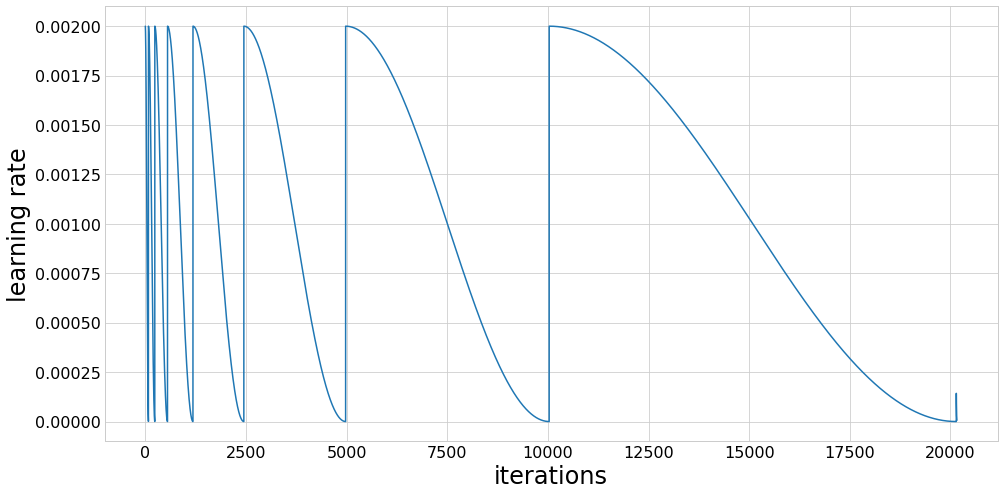

Fold took 259.394s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.396670). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198684). Check your callbacks.
  % delta_t_median)


1 New best found: 4.0083166448657194e-05
2 New best found: 3.64065153100869e-05
3 New best found: 3.59060359126485e-05
4 New best found: 3.548912972686568e-05
5 New best found: 3.47390718141195e-05
6 New best found: 3.4326458045678084e-05
7 New best found: 3.419684437030894e-05
10 New best found: 3.381424836612783e-05
11 New best found: 3.3558938909006715e-05
13 New best found: 3.3231101881070665e-05
14 New best found: 3.3138979657154125e-05
15 New best found: 3.3136990609204274e-05
22 New best found: 3.303054477810543e-05
23 New best found: 3.2878847410803976e-05
25 New best found: 3.25295365152508e-05
27 New best found: 3.243728977482901e-05
29 New best found: 3.24099197511542e-05
31 New best found: 3.2399204431385576e-05
48 New best found: 3.236179042254959e-05
51 New best found: 3.2189249375368384e-05
53 New best found: 3.217233480109856e-05
54 New best found: 3.212259635230128e-05
55 New best found: 3.2077057967318064e-05
56 New best found: 3.2047175842147944e-05
59 New best found

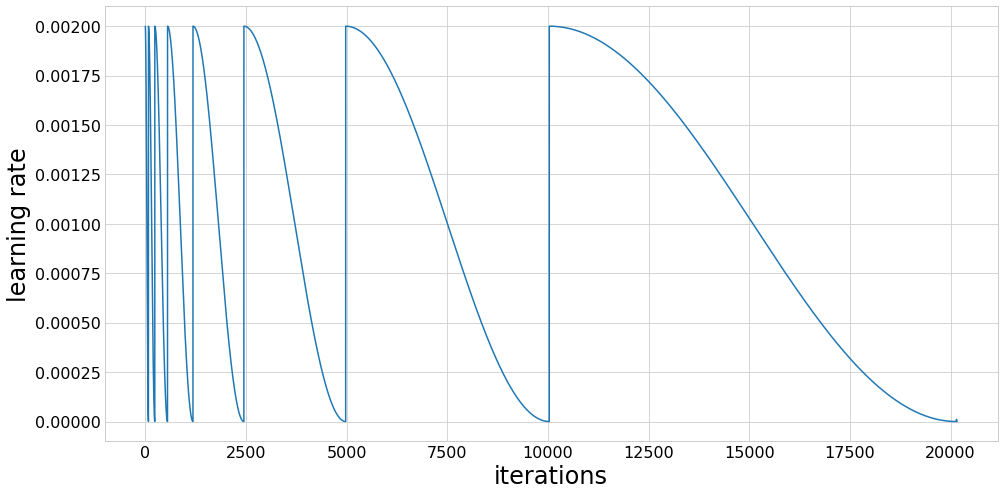

Fold took 258.669s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.441805). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.221297). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9713856664607806e-05
2 New best found: 3.6848759833928555e-05
3 New best found: 3.578125215127344e-05
4 New best found: 3.558777721937716e-05
5 New best found: 3.487844054270975e-05
6 New best found: 3.466053280918238e-05
7 New best found: 3.430443252841773e-05
11 New best found: 3.418019070856537e-05
12 New best found: 3.3550242093051744e-05
13 New best found: 3.349141826443827e-05
14 New best found: 3.334896652213659e-05
15 New best found: 3.3345610945526916e-05
19 New best found: 3.3345557966335095e-05
21 New best found: 3.328371138947258e-05
23 New best found: 3.326702131665756e-05
24 New best found: 3.321388390720314e-05
25 New best found: 3.290640771049739e-05
27 New best found: 3.287607639020886e-05
28 New best found: 3.282524403925864e-05
29 New best found: 3.274899158593386e-05
30 New best found: 3.271909691820784e-05
31 New best found: 3.271617206050465e-05
48 New best found: 3.2640386127282816e-05
50 New best found: 3.261282917256313e-05
55 New best found

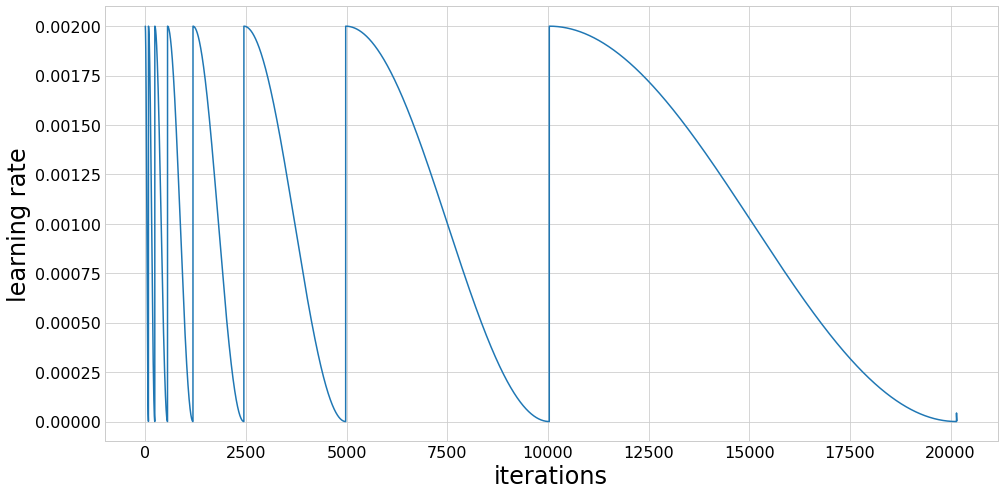

Fold took 265.340s


______________________________________
Training finished
Cross-validation took 2459.575s 


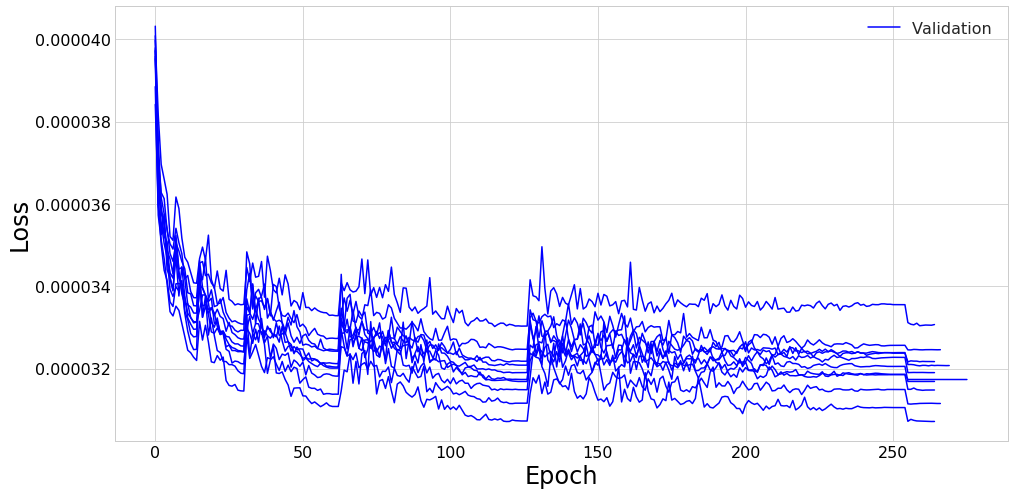

Mean loss = 3.18e-05 +- 2e-07
Mean wAUC = 0.0636 +- 0.0008
Mean AUC = 0.0993 +- 0.0008
Mean AMS = 3.83 +- 0.08
Mean cut = 0.962 +- 0.006
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [10]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [11]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 5 with loss = 3.071348240046064e-05
Model 1 is 3 with loss = 3.113673938305498e-05
Model 2 is 6 with loss = 3.1469871602166675e-05
Model 3 is 8 with loss = 3.168617265697667e-05
Model 4 is 1 with loss = 3.1733870216871865e-05
Model 5 is 4 with loss = 3.18965626445567e-05
Model 6 is 7 with loss = 3.206622785728541e-05
Model 7 is 9 with loss = 3.216255729363532e-05
Model 8 is 0 with loss = 3.245246281768314e-05
Model 9 is 2 with loss = 3.302091966033913e-05


## Response on validation data without TTA

In [12]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [13]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0018132910195738077s per sample

Predicting fold 2 out of 10
Prediction took 0.00032062198389321564s per sample

Predicting fold 3 out of 10
Prediction took 0.0003235818633809686s per sample

Predicting fold 4 out of 10
Prediction took 0.00032144879773259163s per sample

Predicting fold 5 out of 10
Prediction took 0.0003205378940328956s per sample

Predicting fold 6 out of 10
Prediction took 0.00032203783802688124s per sample

Predicting fold 7 out of 10
Prediction took 0.0003232830435037613s per sample

Predicting fold 8 out of 10
Prediction took 0.00032225731015205383s per sample

Predicting fold 9 out of 10
Prediction took 0.00032422804087400435s per sample

Predicting fold 10 out of 10
Prediction took 0.00032099745590239765s per sample



In [14]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [15]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9028289688893786, weighted 0.9356320493186333


Best cut at 0.9678633560289491 corresponds to AMS of 3.8920410576244957
Maximum AMS for data is 3.933460631989226 at cut of 0.9616554975509644
CPU times: user 24.8 s, sys: 0 ns, total: 24.8 s
Wall time: 24.8 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


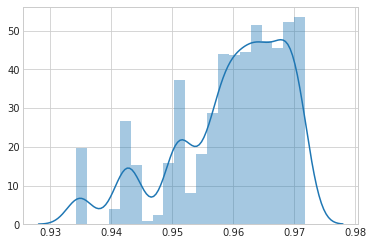

In [16]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9596599 corresponds to AMS of 3.8647096666191514
Maximum AMS for data is 3.933460631989226 at cut of 0.9616554975509644
CPU times: user 96.1 ms, sys: 82.9 ms, total: 179 ms
Wall time: 84.9 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


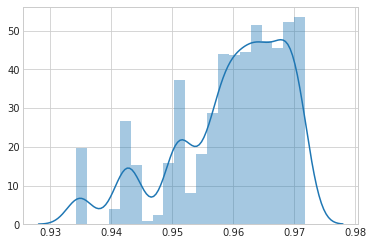

In [17]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [18]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), reflect_z=False,
                             input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [19]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.005388934881985188s per sample

Predicting fold 2 out of 10
Prediction took 0.005377166054211557s per sample

Predicting fold 3 out of 10
Prediction took 0.005379628059640527s per sample

Predicting fold 4 out of 10
Prediction took 0.005393502093106508s per sample

Predicting fold 5 out of 10
Prediction took 0.005398825603537261s per sample

Predicting fold 6 out of 10
Prediction took 0.005391670303232968s per sample

Predicting fold 7 out of 10
Prediction took 0.005386700981110335s per sample

Predicting fold 8 out of 10
Prediction took 0.005404887061007321s per sample

Predicting fold 9 out of 10
Prediction took 0.005391421396285296s per sample

Predicting fold 10 out of 10
Prediction took 0.0053663132498040795s per sample



In [20]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [21]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.9029417078988947, weighted 0.9356652117767329


Best cut at 0.9648214607864052 corresponds to AMS of 3.853024145710286
Maximum AMS for data is 3.8884392026295163 at cut of 0.9609285593032837
CPU times: user 24.8 s, sys: 0 ns, total: 24.8 s
Wall time: 24.8 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


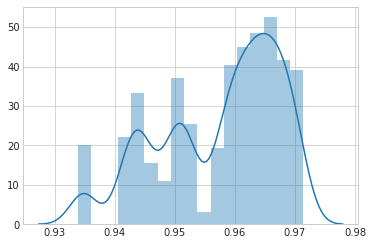

In [22]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9574943 corresponds to AMS of 3.812526758223604
Maximum AMS for data is 3.8884392026295163 at cut of 0.9609285593032837
CPU times: user 91 ms, sys: 90.5 ms, total: 182 ms
Wall time: 82.2 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


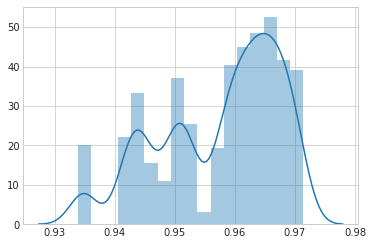

In [23]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [24]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [25]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0003229102794250304s per sample

Predicting fold 2 out of 10
Prediction took 0.0003234520817683502s per sample

Predicting fold 3 out of 10
Prediction took 0.000322620394284075s per sample

Predicting fold 4 out of 10
Prediction took 0.0003211337052624334s per sample

Predicting fold 5 out of 10
Prediction took 0.00031967812150039454s per sample

Predicting fold 6 out of 10
Prediction took 0.00032111914415251124s per sample

Predicting fold 7 out of 10
Prediction took 0.00032484523548998616s per sample

Predicting fold 8 out of 10
Prediction took 0.0003248097495768558s per sample

Predicting fold 9 out of 10
Prediction took 0.0003224611009894447s per sample

Predicting fold 10 out of 10
Prediction took 0.0003218722334639593s per sample

CPU times: user 3min 12s, sys: 11.6 s, total: 3min 23s
Wall time: 2min 57s


In [26]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.624031866036576 : 3.649538629388037


(3.624031866036576, 3.649538629388037)

In [27]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.690562557763732 : 3.7654529806869226


(3.690562557763732, 3.7654529806869226)

# Test scoring - With TTA

In [28]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), reflect_z=False,
                             input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [29]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0051864120402119376s per sample

Predicting fold 2 out of 10
Prediction took 0.005197534994069826s per sample

Predicting fold 3 out of 10
Prediction took 0.00518551687088541s per sample

Predicting fold 4 out of 10
Prediction took 0.005193103983016176s per sample

Predicting fold 5 out of 10
Prediction took 0.005168278049694544s per sample

Predicting fold 6 out of 10
Prediction took 0.005173336210965433s per sample

Predicting fold 7 out of 10
Prediction took 0.0051740275477143854s per sample

Predicting fold 8 out of 10
Prediction took 0.005180523369766095s per sample

Predicting fold 9 out of 10
Prediction took 0.005192552588744597s per sample

Predicting fold 10 out of 10
Prediction took 0.005188491868075322s per sample

CPU times: user 51min 32s, sys: 2min 56s, total: 54min 29s
Wall time: 47min 31s


In [30]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.6300385353145583 : 3.7135467227494416


(3.6300385353145583, 3.7135467227494416)

In [31]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.743120337038775 : 3.761377218589822


(3.743120337038775, 3.761377218589822)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)